In [ ]:
from collections import namedtuple, deque
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define the Grid World environment
class GridWorld:
    def __init__(self):
        """
            0  1  2  3
        0 | 0  0  0  +1
        1 | 0  x  0  -1      x = obstacle
        2 | s  0  0  0       s = agent starting position
        """
        # state: 0=[0,0], 1=[0,1], 2=[0,2], 3=[0,3], 4=[1,0], ..., 10=[2,2], 11=[2,3]
        # action: 0=up, 1=down, 2=left, 3=right

        #final map
        self.nrows = 12
        self.ncolumns = 12
        self.goal_rc = [(10,10)]
        self.trap_rc = [(2,9),
                        (4,9),(4,10),
                        (7,10),(8,10),(9,10),(10,8)]
        self.WALL_RC = [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11),
                        (11, 0), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6), (11, 7), (11, 8), (11, 9), (11, 10), (11, 11),
                        (1, 0),(2, 0), (3, 0),(4, 0),(5, 0),(6, 0),(7, 0),(8, 0),(9, 0),(10, 0),
                        (1, 11),(2, 11), (3, 11),(4, 11),(5, 11),(6, 11),(7, 11),(8, 11),(9, 11),(10, 11),

                        (1,4),
                        (2,2),(2,4),(2,6),(2,7),(2,8),
                        (3,7),
                        (4,2),(4,3),(4,5),(4,7),
                        (5,7),
                        (6,1),(6,2),(6,3),(6,4),(6,5),(6,6),(6,7),(6,8),
                        (8,3),(8,4),(8,5),(8,6),(8,7),(8,8),(8,9),
                        (9,2),(9,3),(9,4),(9,5),(9,6)]

        """#hard map
        self.nrows = 12
        self.ncolumns = 12
        self.goal_rc = [(8,9)]
        self.trap_rc = [(7,6),
                        (8,8),
                        (9,8),(9,9),(9,10)]
        self.WALL_RC = [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11),
                        (11, 0), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6), (11, 7), (11, 8), (11, 9), (11, 10), (11, 11),
                        (1, 0),(2, 0), (3, 0),(4, 0),(5, 0),(6, 0),(7, 0),(8, 0),(9, 0),(10, 0),
                        (1, 11),(2, 11), (3, 11),(4, 11),(5, 11),(6, 11),(7, 11),(8, 11),(9, 11),(10, 11),

                        (1,6),
                        (2,6),
                        (3,2),(3,3),(3,4),(3,6),(3,8),(3,9),
                        (4,4),(4,8),
                        (5,1),(5,4),(5,8),
                        (6,2),(6,4),(6,6),(6,7),(6,8),(6,9),(6,10),
                        (7,2),(7,4),
                        (8,4),(8,6),
                        (9,2),(9,4),(9,6),
                        (10,2)
                        ]
        """
        """#easy map
        self.nrows = 5
        self.ncolumns = 5
        self.goal_rc = [(0,4)]
        self.trap_rc = [(4,0)]
        self.WALL_RC = [(1,2),(1,3),
                        (2,1),(2,2),(2,3),
                       (3,1),(3,2),(3,3)]"""

        self.rewards = np.zeros((self.nrows, self.ncolumns))
        self.rewards[tuple(zip(*self.goal_rc))] = 1 # the goal state, reward = 1
        self.rewards[tuple(zip(*self.trap_rc))] = -1 # the lose state, reward = -1

        #start from 0
        self.actions = ['up', 'down', 'left', 'right']
        self.agent_init_pos = [1,1]
        self.agent_pos = self.agent_init_pos  # starting position of the agent

    def step(self, action):
        """
        Given an action (0=up, 1=down, 2=left, 3=right),
        return the next valid state index (0~11) and reward R(s,a)
        """
        r, c = self.agent_pos #row, column
        if action == 0:  # move up
            r = max(r - 1, 0)
        elif action == 1:  # move down
            r = min(r + 1, self.nrows-1)
        elif action == 2:  # move left
            c = max(c - 1, 0)
        elif action == 3:  # move right
            c = min(c + 1, self.ncolumns-1)

        if (r,c) not in self.WALL_RC:  #if not blocked
            self.agent_pos = [r, c] #agent moved
            reward = 0
        else: #if blocked
            reward = -0.5#-0.5

        reward += -0.04
        reward += self.rewards[self.agent_pos[0], self.agent_pos[1]]

        return self.agentPosIndex(), reward

    def isTerminal(self):
        """
        Return True if the agent is at a terminal state
        """
        return tuple(self.agent_pos) in self.goal_rc #or tuple(self.agent_pos) in self.trap_rc

    def reset(self):
        """
        Reset the grid world
        """
        self.agent_pos = self.agent_init_pos  # reset to starting position

    def agentPosIndex(self):
        """
        Return the current position index (0-11) of the agent in the grid world
        0=[0,0], 1=[0,1], 2=[0,2], 3=[0,3], 4=[1,0], ..., 10=[2,2], 11=[2,3]
        """
        return self.agent_pos[0] * self.nrows + self.agent_pos[1]

    def gridSize(self):
        """
        Return the size of the GridWorld
        """
        return (self.nrows * self.ncolumns)

    def numActions(self):
        """
        Return the number of actions
        """
        return len(self.actions)

    def showGrid(self):
        """
        Display the Grid World
        """
        for i in range(0, self.nrows):
            print('-------------------------------------------------')
            out = '| '
            for j in range(0, self.ncolumns):
                token = ' '
                if (i,j) in self.WALL_RC: # obstacle
                    token = 'X'
                if (i,j) in self.goal_rc: # goal state
                    token = 'G'
                if (i,j) in self.trap_rc: # lose state
                    token = 'L'
                if i == self.agent_pos[0] and j == self.agent_pos[1]: # agent pos
                    token = '*'

                out += token + ' | '
            print(out)
        print('-------------------------------------------------')

In [ ]:
env = GridWorld()
env.showGrid()

-------------------------------------------------
| X | X | X | X | X | X | X | X | X | X | X | X | 
-------------------------------------------------
| X | * |   |   | X |   |   |   |   |   |   | X | 
-------------------------------------------------
| X |   | X |   | X |   | X | X | X | L |   | X | 
-------------------------------------------------
| X |   |   |   |   |   |   | X |   |   |   | X | 
-------------------------------------------------
| X |   | X | X |   | X |   | X |   | L | L | X | 
-------------------------------------------------
| X |   |   |   |   |   |   | X |   |   |   | X | 
-------------------------------------------------
| X | X | X | X | X | X | X | X | X |   |   | X | 
-------------------------------------------------
| X |   |   |   |   |   |   |   |   |   | L | X | 
-------------------------------------------------
| X |   |   | X | X | X | X | X | X | X | L | X | 
-------------------------------------------------
| X |   | X | X | X | X | X |   |   |   |

In [ ]:
env.agent_pos = [7, 8]
next_state, reward = env.step(action=3)
print(reward)
print(env.isTerminal())
env.showGrid()

-0.04
False
-------------------------------------------------
| X | X | X | X | X | X | X | X | X | X | X | X | 
-------------------------------------------------
| X |   |   |   | X |   |   |   |   |   |   | X | 
-------------------------------------------------
| X |   | X |   | X |   | X | X | X | L |   | X | 
-------------------------------------------------
| X |   |   |   |   |   |   | X |   |   |   | X | 
-------------------------------------------------
| X |   | X | X |   | X |   | X |   | L | L | X | 
-------------------------------------------------
| X |   |   |   |   |   |   | X |   |   |   | X | 
-------------------------------------------------
| X | X | X | X | X | X | X | X | X |   |   | X | 
-------------------------------------------------
| X |   |   |   |   |   |   |   |   | * | L | X | 
-------------------------------------------------
| X |   |   | X | X | X | X | X | X | X | L | X | 
-------------------------------------------------
| X |   | X | X | X | X | X |

In [ ]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
MEMORY_CAPACITY = 10000
memory = ReplayMemory(MEMORY_CAPACITY)

# Define the Q-learning agent
class QLearningAgent:
    def __init__(self, n_states, n_actions, alpha=0.5, GAMMA=0.9, epsilon=0.5, exploration_proba_decay = 0.08, BATCH_SIZE=32):
        self.N_STATES = n_states
        self.N_ACTIONS = n_actions
        self.alpha = alpha
        self.GAMMA = GAMMA
        self.epsilon = epsilon
        self.explore_decay = exploration_proba_decay
        self.BATCH_SIZE = BATCH_SIZE
        self.TAU = 0.005

        self.policy_net = DQN(self.N_STATES, self.N_ACTIONS).to(device)
        self.target_net = DQN(self.N_STATES, self.N_ACTIONS).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=1e-3)

    def choose_action(self, state):
        """
        Epsilon-greedy policy: with probability epsilon, choose a random action,
        otherwise choose the action with the highest Q-value for the state
        """
        if np.random.uniform() < self.epsilon:
            action = np.random.randint(self.N_ACTIONS)
        else:
            action = torch.argmax(self.policy_net(state), dim=1)
            action = action.item()
        return action

    def update(self):
        transitions = memory.sample(self.BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        #get batch data
        state_batch = torch.cat(batch.state) #(b,c,h,w)
        action_batch = torch.cat(batch.action) #(b,1)
        reward_batch = torch.cat(batch.reward) #(b)

        #next_state included None for terminal state
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool) #(b)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None]) #(b,c,h,w)
        #compute Q(s,a)
        state_action_values = self.policy_net(state_batch).gather(1, action_batch) #compute Q(s,a) for all a. select the a based on action_batch

        #terminal state will have V(s)=0
        next_state_values = torch.zeros(self.BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0] #get the highest next state value

        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch

        # Clear all the gradient to 0
        self.optimizer.zero_grad()
        # Compute Huber loss
        criterion = nn.MSELoss() #or criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        loss.backward()

        # In-place gradient clipping
        #torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
        self.optimizer.step()
        return loss.item()

    def train(self, env, n_episodes=1000, max_steps=1000):
        """
        Train the agent to navigate in the given environment using deep Q-learning
        """
        print('Training starts...')
        rewards_history = []

        for episode in range(n_episodes):
            env.reset() # reset the environment
            state = self.toTensor(env.agentPosIndex())  # starting state

            n_steps = 0
            total_reward = 0
            done = False
            while not done:
                """step 1: choose action for current state"""
                action = self.choose_action(state)

                """step 2: take the action, get the reward and next_state"""
                next_state, reward = env.step(action)
                next_state = self.toTensor(next_state)

                """step 3: Store the transition in memory"""
                memory.push(state, torch.tensor([[action]]).to(device), next_state, torch.tensor([reward], dtype=torch.float32).to(device)) #s:(1,c), a:(1,1), s_:(1,c), r:(1)

                """step 4: Sample data, optimize policy network, update target network"""
                if len(memory) > self.BATCH_SIZE:
                    self.update() #sample data and optimize policy network
                    #update target network
                    target_net_state_dict = self.target_net.state_dict()
                    policy_net_state_dict = self.policy_net.state_dict()
                    for key in policy_net_state_dict:
                        target_net_state_dict[key] = policy_net_state_dict[key]*self.TAU + target_net_state_dict[key]*(1-self.TAU)
                    self.target_net.load_state_dict(target_net_state_dict)

                """step 5: set state to next_state"""
                state = next_state

                # stop if terminal state or n_steps >= max_steps
                n_steps += 1
                total_reward += reward
                if env.isTerminal() or n_steps >= max_steps:
                    print(f'Episode: {episode+1}, Total Reward: {total_reward:.2f},\tEpsilon: {self.epsilon:.2f}, Reached Goal: {env.isTerminal()}')
                    done = True
                if env.isTerminal():
                    self.epsilon = self.epsilon * np.exp(-self.explore_decay)
            rewards_history.append(total_reward)

        print('...Training completed!')
        return rewards_history

    def toTensor(self, state_idx):
        state = torch.zeros(self.N_STATES).to(device)
        state[state_idx] = 1.0
        state = torch.unsqueeze(state,0)
        return state #(1,c:N_STATES)

    def play(self, env, max_steps=100, show_grid=False):
        """
        Play/Test the trained Q-learning agent
        """
        env.reset() # reset to starting state
        state = self.toTensor(env.agentPosIndex())
        done = False
        n_steps = 0

        while not done:
            action = torch.argmax(self.policy_net(state), dim=1).item()  # action = np.argmax(self.q_table[state])

            if show_grid:
                env.showGrid()
                print(f'action = {action} ({env.actions[action]})')

            next_state, reward = env.step(action)
            state = self.toTensor(next_state)

            n_steps += 1
            if n_steps > max_steps:
                done = True
                print("Failed to reach goal after", max_steps, "steps!")

            if env.isTerminal():
                done = True
                print(f"Goal reached with {n_steps} steps!")


In [ ]:
def plot(y,x_label="x", y_label="y", title=None):
    x = list(range(len(y)))

    plt.plot(x, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if title is None:
        plt.title(y_label + " VS " + x_label)
    else:
        plt.title(title)
    plt.show()

In [ ]:
env = GridWorld()
agent = QLearningAgent(env.gridSize(), env.numActions(), alpha=0.5, GAMMA=0.9, epsilon=0.3, exploration_proba_decay = 0.01, BATCH_SIZE=32)
rewards_history = agent.train(env, n_episodes=700, max_steps=1000)

Training starts...
Episode: 1, Total Reward: -172.00,	Epsilon: 0.30, Reached Goal: False
Episode: 2, Total Reward: -115.00,	Epsilon: 0.30, Reached Goal: False
Episode: 3, Total Reward: -120.50,	Epsilon: 0.30, Reached Goal: False
Episode: 4, Total Reward: -128.50,	Epsilon: 0.30, Reached Goal: False
Episode: 5, Total Reward: -115.00,	Epsilon: 0.30, Reached Goal: False
Episode: 6, Total Reward: -113.50,	Epsilon: 0.30, Reached Goal: False
Episode: 7, Total Reward: -104.00,	Epsilon: 0.30, Reached Goal: False
Episode: 8, Total Reward: -97.00,	Epsilon: 0.30, Reached Goal: False
Episode: 9, Total Reward: -105.00,	Epsilon: 0.30, Reached Goal: False
Episode: 10, Total Reward: -99.50,	Epsilon: 0.30, Reached Goal: False
Episode: 11, Total Reward: -104.00,	Epsilon: 0.30, Reached Goal: False
Episode: 12, Total Reward: -119.50,	Epsilon: 0.30, Reached Goal: False
Episode: 13, Total Reward: -94.00,	Epsilon: 0.30, Reached Goal: False
Episode: 14, Total Reward: -111.00,	Epsilon: 0.30, Reached Goal: False

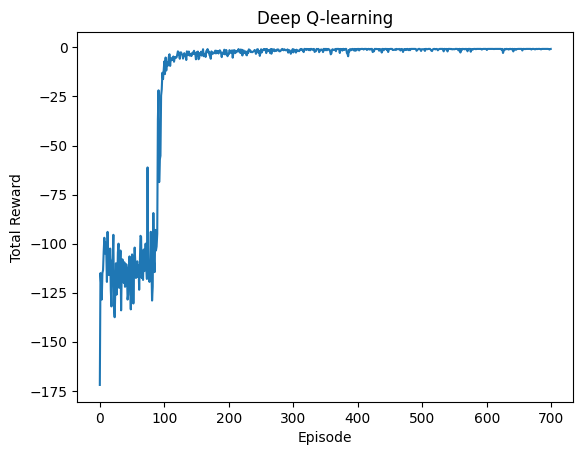

In [ ]:
plot(y=rewards_history, x_label="Episode", y_label="Total Reward", title="Deep Q-learning")

In [ ]:
# Test the trained Q-learning agent
agent.play(env, max_steps=60, show_grid=True)

-------------------------------------------------
| X | X | X | X | X | X | X | X | X | X | X | X | 
-------------------------------------------------
| X | * |   |   | X |   |   |   |   |   |   | X | 
-------------------------------------------------
| X |   | X |   | X |   | X | X | X | L |   | X | 
-------------------------------------------------
| X |   |   |   |   |   |   | X |   |   |   | X | 
-------------------------------------------------
| X |   | X | X |   | X |   | X |   | L | L | X | 
-------------------------------------------------
| X |   |   |   |   |   |   | X |   |   |   | X | 
-------------------------------------------------
| X | X | X | X | X | X | X | X | X |   |   | X | 
-------------------------------------------------
| X |   |   |   |   |   |   |   |   |   | L | X | 
-------------------------------------------------
| X |   |   | X | X | X | X | X | X | X | L | X | 
-------------------------------------------------
| X |   | X | X | X | X | X |   |   |   |

In [ ]:
#torch.save(agent, "myAgent.pt")